<a href="https://colab.research.google.com/github/yusufbingol/sign_verification/blob/main/signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pathlib

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout,BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.regularizers import l2
from keras.models import Sequential, Model

import itertools
from sklearn.utils import shuffle
import seaborn as sn

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import keras.backend as K
import random

In [3]:
img_h, img_w = 155,220

In [4]:
def get_all_path(current_person, sign_type):
  imgs = []
  for i in range(1, 25):
      img_path = f'/content/drive/MyDrive/Colab_Notebooks/signatures/{sign_type}_{current_person}_{i}.png'
      imgs.append(img_path)
  
  return imgs # Returns the path of the image.

In [5]:
def thresholding(img):
  uintImage = tf.keras.preprocessing.image.img_to_array(img, dtype='uint8') # Img to array.
  withBlur = cv2.GaussianBlur(uintImage,(5,5),0)  # Image is filtered with a 5x5 gaussian kernel to remove the noise.
  (thresh, withOtsu) = cv2.threshold(withBlur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # Otsu thresholding with inverse-binary is applied.
  bilinear_img = cv2.resize(withOtsu,(img_w,img_h), interpolation = cv2.INTER_LINEAR) # Resizing with bilinear interpolation.
  return bilinear_img

In [6]:
def centering(img,tol=0):   # Removes null spaces.
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

Gets all the paths.

In [7]:
path_originals = []
path_forgeries = []
for i in range(1,56): 
  path_originals.append(get_all_path(i,'full_org/original'))
  path_forgeries.append(get_all_path(i,'full_forg/forgeries'))

For test.

In [8]:
img = cv2.imread(path_originals[5][2],0) 
imgTresh=thresholding(img)
imgThreshCrop = centering(imgTresh)

For display to test image.

(-0.5, 201.5, 65.5, -0.5)

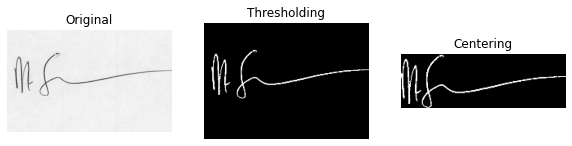

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
ax1.imshow(img, cmap = 'gray')
ax2.imshow(imgTresh, cmap = 'gray')
ax3.imshow(imgThreshCrop, cmap = 'gray')
ax1.set_title('Original')
ax1.axis('off')
ax2.set_title('Thresholding')
ax2.axis('off')
ax3.set_title('Centering')
ax3.axis('off')

There are 24 signatures for 55 signers.

In [10]:
print(len(path_originals))
orig_lengths = [len(x) for x in path_originals]
print(orig_lengths)

55
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


I took generate_batch method from GitHub and changed little bit.
GitHub link is in README.md

In [11]:
def generate_batch(orig_groups, forg_groups, batch_size = 128):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 288 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 55 * 276 = 15180
        # Total number of Genuine-Forged pairs = 55 * 288 = 15840
        # Total no. of data points = 15180 + 15840 = 31020
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)

            # I added methods (thresholding, centering) below to improve accuracy.

            img1 = thresholding(img1) 
            img2 = thresholding(img2) 

            img1 = centering(img1,10) 
            img2 = centering(img2,10) 

            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))

            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))


In [12]:
orig_train, orig_val, orig_test = path_originals[:45], path_originals[45:50], path_originals[50:]
forg_train, forg_val, forg_test = path_forgeries[:45], path_forgeries[45:50], path_forgeries[50:]

In [13]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = cv2.imread(forg_img_name[0], 0)

    orig_img1 = thresholding(orig_img1)
    orig_img2 = thresholding(orig_img2)
    forg_img = thresholding(forg_img)

    orig_img2 = centering(orig_img2,10)
    orig_img1 = centering(orig_img1,10)
    forg_img = centering(forg_img,10)

    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

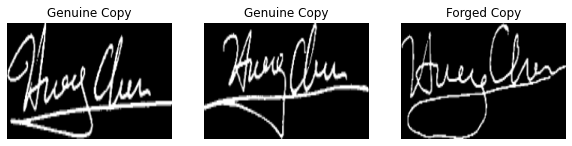

In [ ]:
visualize_sample_signature()

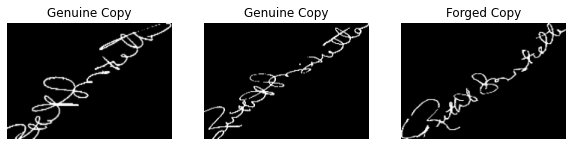

In [ ]:
visualize_sample_signature()

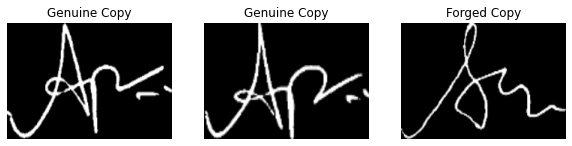

In [ ]:
visualize_sample_signature()

In [14]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0) ))

In [16]:
def Signet(input_shape):

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    
    return seq

In [17]:
input_shape=(img_h, img_w, 1)

In [18]:
# network definition
base_network = Signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [19]:
rms = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          6461084     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

You can get almost %100 accuracy with these values. (CEDAR database)

In [21]:
'''
batch_sz = 128
num_train_samples = 276*55 + 288*55
num_val_samples = num_test_samples = 276*5 + 288*5
num_train_samples, num_val_samples, num_test_samples

results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz)
'''

(31020, 2820, 2820)

In [ ]:
results = model.fit(generate_batch(orig_train, forg_train, 128),
                              steps_per_epoch = 60,
                              epochs = 10,
                              validation_data = generate_batch(orig_val, forg_val, 128),
                              validation_steps = 30)

Epoch 1/10
60/60 [==============================] - 1522s 25s/step - loss: 8.5604 - val_loss: 1.4258
Epoch 2/10
60/60 [==============================] - 1366s 23s/step - loss: 1.1860 - val_loss: 1.3797
Epoch 3/10
60/60 [==============================] - 1363s 23s/step - loss: 1.1274 - val_loss: 1.2853
Epoch 4/10
60/60 [==============================] - 1351s 23s/step - loss: 1.0060 - val_loss: 1.1076
Epoch 5/10
60/60 [==============================] - 1362s 23s/step - loss: 0.8620 - val_loss: 0.9295
Epoch 6/10
60/60 [==============================] - 1347s 23s/step - loss: 0.7354 - val_loss: 0.8339
Epoch 7/10
60/60 [==============================] - 1352s 23s/step - loss: 0.6217 - val_loss: 0.6915
Epoch 8/10
60/60 [==============================] - 1350s 23s/step - loss: 0.5364 - val_loss: 0.5732
Epoch 9/10
60/60 [==============================] - 1362s 23s/step - loss: 0.4722 - val_loss: 0.5410
Epoch 10/10
60/60 [==============================] - 1359s 23s/step - loss: 0.4194 - val_lo

In [22]:
# Function to compute accuracy
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
     
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
       
        if (acc > max_acc):
            max_acc, best_thresh, best_tpr, best_tnr = acc, d, tpr, tnr
           
    return max_acc, best_thresh, best_tpr, best_tnr

In [ ]:

# Loading the best weights to the model
# model.load_weights('./Weights.h5')


In [23]:
test_gen = generate_batch(orig_test, forg_test, 1) 
pred, tr_y = [], []
for i, j in enumerate(range(2820)):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [24]:
# Accuracy, Threshold, TPR & TNR (Best) 
tr_acc, threshold, best_tpr, best_tnr = compute_accuracy_roc(np.array(pred), np.array(tr_y))
print("Accuracy: ", tr_acc, "\nThreshold: ", threshold, "\nTPR: ", best_tpr,"\nTNR: ", best_tnr)

Accuracy:  0.6874245169082125 
Threshold:  0.06983372449874878 
TPR:  0.6797101449275362 
TNR:  0.6951388888888889


In [25]:
# Predict distance score and classify test images as Genuine or Forged
def predict_score():
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

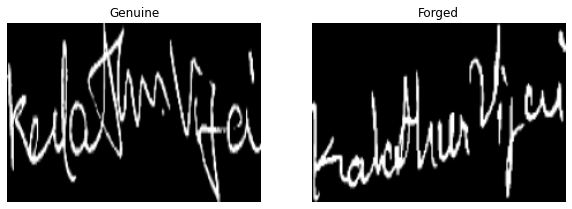

Difference Score =  0.08109162
Its a Forged Signature


In [30]:
predict_score()

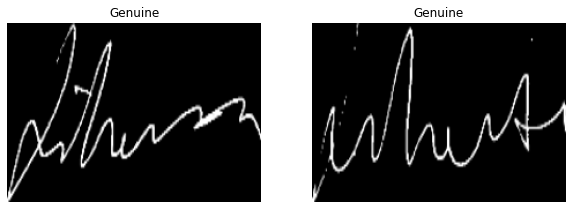

Difference Score =  0.077991255
Its a Forged Signature


In [27]:
predict_score()

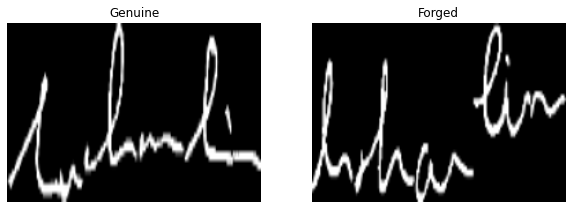

Difference Score =  0.07891124
Its a Forged Signature


In [32]:
predict_score()

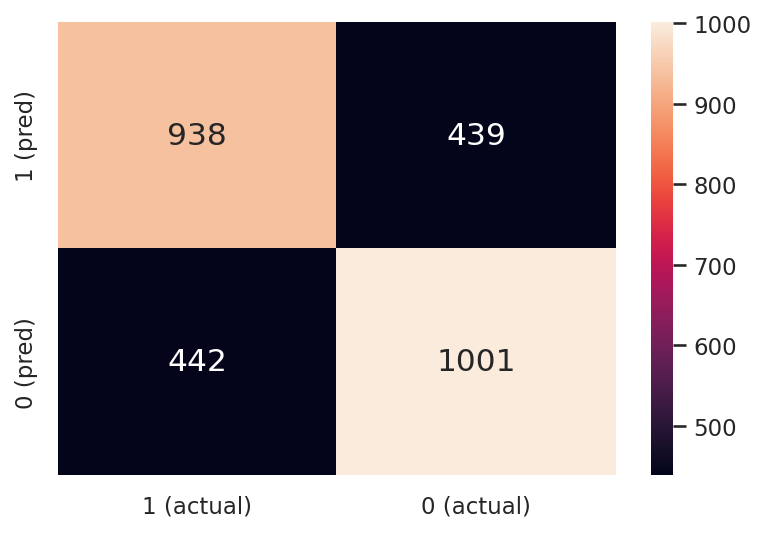

In [33]:
# Confusion Matrix
# Gen-Forged pair (0) 
# Gen-Gen pair (1) 

orig_labels = np.array(tr_y)
pred_labels = np.array(pred)
TP, TN, FP, FN = 0, 0, 0, 0

for i, j in zip(orig_labels, pred_labels):
  if i[0]==0 and j>=threshold:
    TN+=1
  if i[0]==0 and j<threshold:
    FP+=1
  if i[0]==1 and j<threshold:
    TP+=1
  if i[0]==1 and j>=threshold:
    FN+=1

array = [[TP,FP],
         [FN,TN]]

df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(dpi=150)
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g', xticklabels=['1 (actual)','0 (actual)'], yticklabels=['1 (pred)','0 (pred)'])
plt.savefig("confmat.png",dpi=300)
plt.show()